In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import joblib

from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from google.colab import drive

drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/MakineProjeSon/Crop_recommendation.csv")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
print("Veri seti boyutu:", df.shape)
print("\nSütun bilgileri:\n", df.dtypes)


print("\nİstatistiksel özet:\n", df.describe())

print("\nSınıf dağılımı:\n", df['label'].value_counts())

Veri seti boyutu: (2200, 8)

Sütun bilgileri:
 N                int64
P                int64
K                int64
temperature    float64
humidity       float64
ph             float64
rainfall       float64
label           object
dtype: object

İstatistiksel özet:
                  N            P            K  temperature     humidity  \
count  2200.000000  2200.000000  2200.000000  2200.000000  2200.000000   
mean     50.551818    53.362727    48.149091    25.616244    71.481779   
std      36.917334    32.985883    50.647931     5.063749    22.263812   
min       0.000000     5.000000     5.000000     8.825675    14.258040   
25%      21.000000    28.000000    20.000000    22.769375    60.261953   
50%      37.000000    51.000000    32.000000    25.598693    80.473146   
75%      84.250000    68.000000    49.000000    28.561654    89.948771   
max     140.000000   145.000000   205.000000    43.675493    99.981876   

                ph     rainfall  
count  2200.000000  2200.000000 

In [17]:
print("\nEksik değer var mı?\n", df.isnull().sum())


Eksik değer var mı?
 N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64


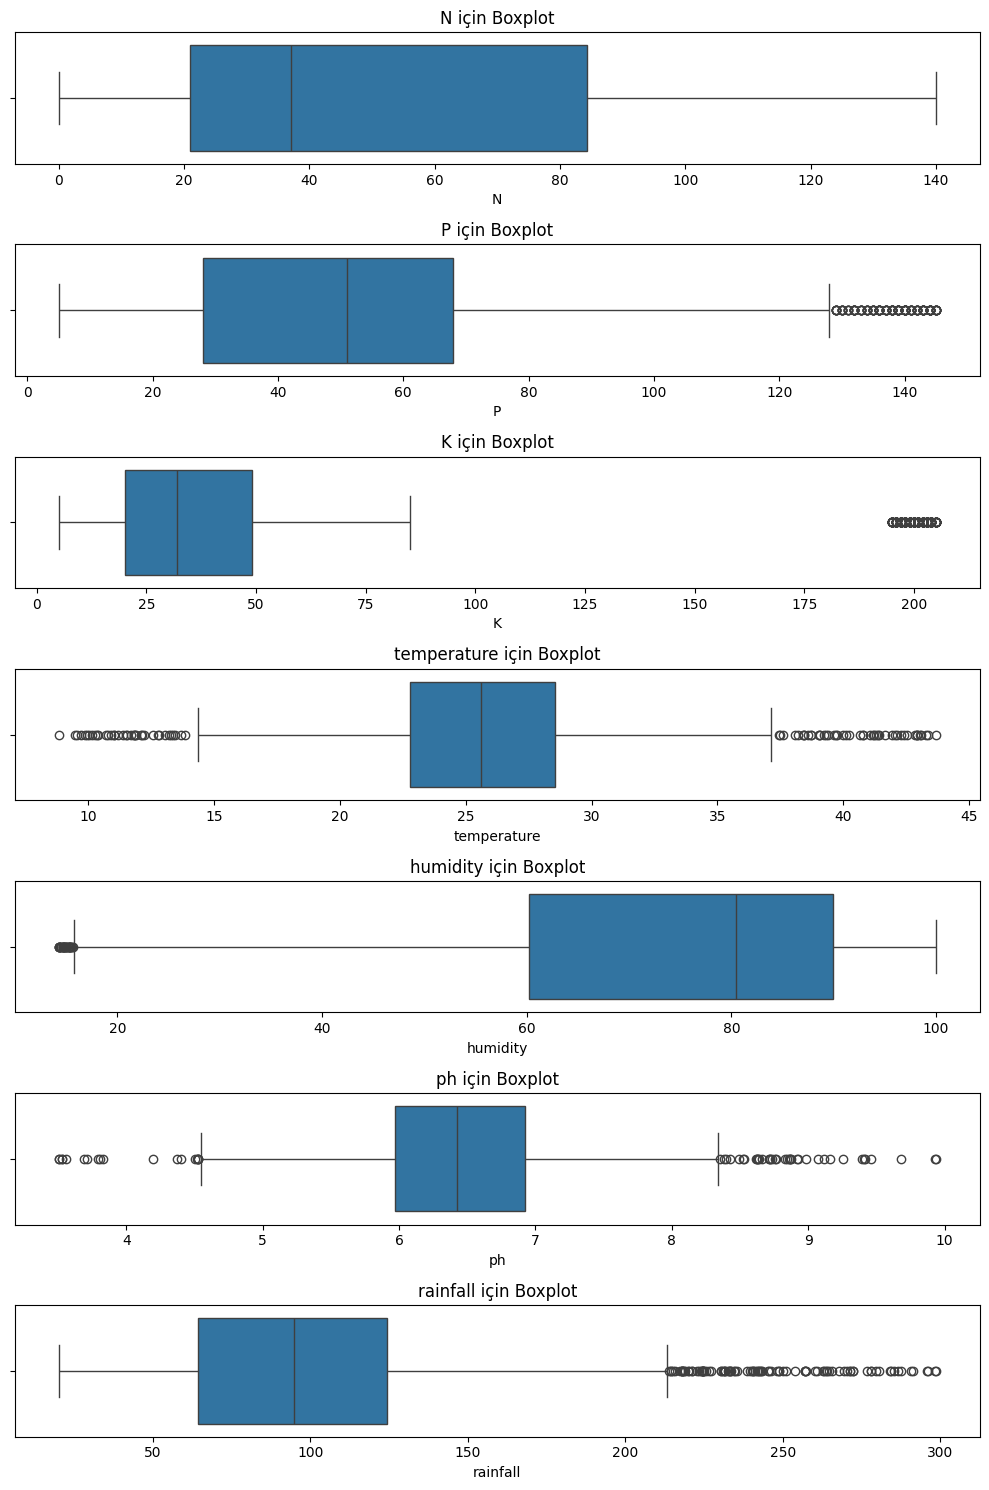

In [18]:
fig, ax = plt.subplots(7, 1, figsize=(10, 15))
fig.subplots_adjust(hspace=0.75)
for i in range(7):

    sns.boxplot(data=df, x=df.columns[i], ax=ax[i], orient='h')
    ax[i].set_title(f'{df.columns[i]} için Boxplot')
plt.tight_layout()
plt.show()

In [19]:
df_clean = df[(np.abs(zscore(df.iloc[:, :-1])) < 3).all(axis=1)]
print("Aykırı değerler temizlendikten sonra yeni boyut:", df_clean.shape)

Aykırı değerler temizlendikten sonra yeni boyut: (2029, 8)


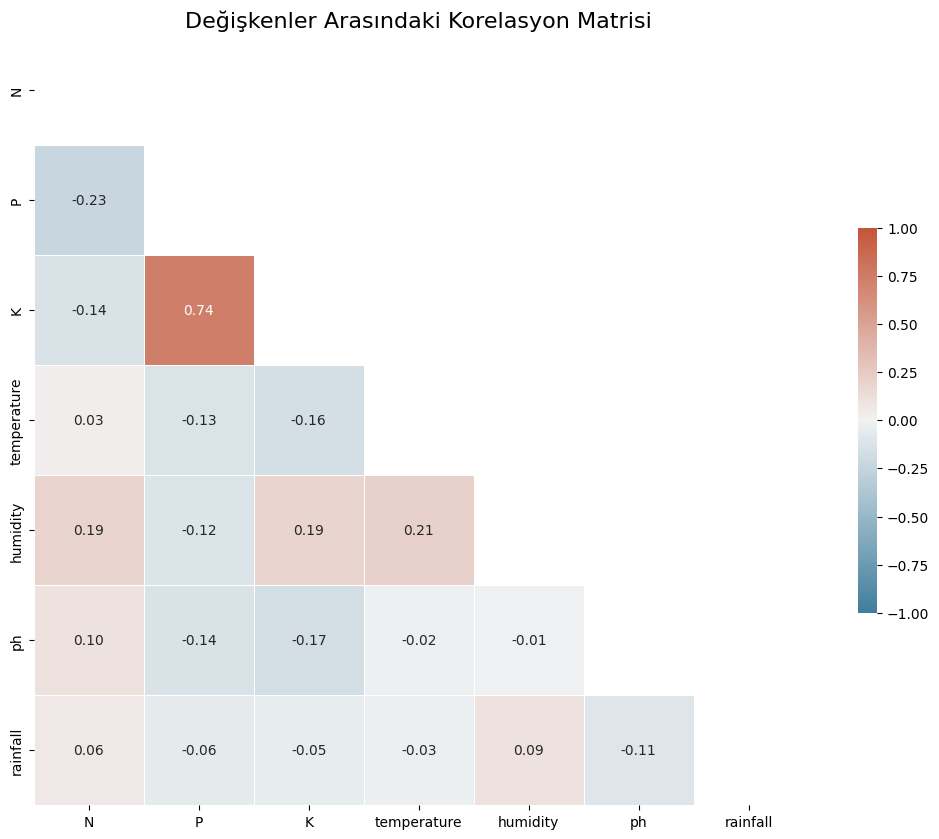

In [20]:

numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
df_numerical = df[numerical_columns]

corr_matrix = df_numerical.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

plt.figure(figsize=(14, 10))

sns.heatmap(corr_matrix, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, fmt=".2f")

plt.title('Değişkenler Arasındaki Korelasyon Matrisi', fontsize=16)

plt.show()


In [21]:
X = df_clean.drop('label', axis=1)
y = df_clean['label']

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

X_normalized_df = pd.DataFrame(X_normalized, columns=X.columns)

X_normalized_df.head()

,N,P,K,temperature,humidity,ph,rainfall
0,1.015677,-0.262625,0.046314,-1.029689,0.499163,0.033854,1.901267
1,0.881973,0.285979,-0.004331,-0.836904,0.424602,0.780895,2.350179
2,0.213452,0.183116,0.071636,-0.569821,0.513251,1.900680,3.056264
3,0.587824,-0.502639,-0.029653,0.184819,0.417457,0.700349,2.656933
4,0.694787,-0.262625,0.020992,-1.191924,0.481537,1.605089,3.032666


In [22]:
#özellik seçimi
skb = SelectKBest(score_func=f_classif, k=5)
X_kbest = skb.fit_transform(X_normalized_df, y)
features_kbest = X_normalized_df.columns[skb.get_support()].tolist()
print("SelectKBest ile seçilen özellikler:", features_kbest)

SelectKBest ile seçilen özellikler: ['N', 'P', 'K', 'humidity', 'rainfall']


In [23]:
mi_scores = mutual_info_classif(X_normalized_df, y)
mi_series = pd.Series(mi_scores, index=X_normalized_df.columns).sort_values(ascending=False)

features_mi = mi_series.head(5).index.tolist()
X_mi = X_normalized_df[features_mi]
print("Mutual Information ile seçilen özellikler:", features_mi)

Mutual Information ile seçilen özellikler: ['humidity', 'rainfall', 'K', 'P', 'N']


In [24]:
# Model eğitimi
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_normalized_df, y)

rf_importances = pd.Series(rf.feature_importances_, index=X_normalized_df.columns).sort_values(ascending=False)

features_rf = rf_importances.head(5).index.tolist()
X_rf = X_normalized_df[features_rf]
print("Random Forest ile seçilen özellikler:", features_rf)

Random Forest ile seçilen özellikler: ['rainfall', 'humidity', 'K', 'P', 'N']



=== LogisticRegression with SelectKBest (N, P, K, humidity, rainfall) ===
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        11
      banana       1.00      1.00      1.00        20
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        19
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00         9
        jute       0.79      0.95      0.86        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      0.95      0.97        20
       maize       1.00      1.00      1.00        20
       mango       1.00      1.00      1.00        20
   mothbeans       0.94      1.00      0.97        15
    mungbean       0.83      1.00      0.91        20
   muskmelon       1.00      1.00      1.00        20
      

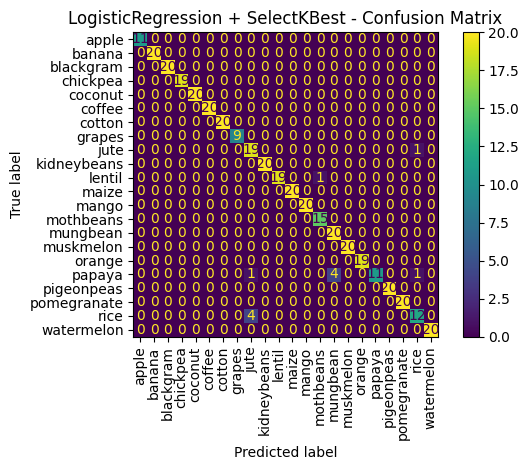


=== SVM with SelectKBest (N, P, K, humidity, rainfall) ===
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        11
      banana       1.00      1.00      1.00        20
   blackgram       0.95      1.00      0.98        20
    chickpea       1.00      1.00      1.00        19
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       0.95      1.00      0.98        20
      grapes       1.00      1.00      1.00         9
        jute       0.79      0.95      0.86        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      1.00      1.00        20
       maize       1.00      0.95      0.97        20
       mango       1.00      1.00      1.00        20
   mothbeans       1.00      1.00      1.00        15
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      1.00      1.00        20
      orange       1.

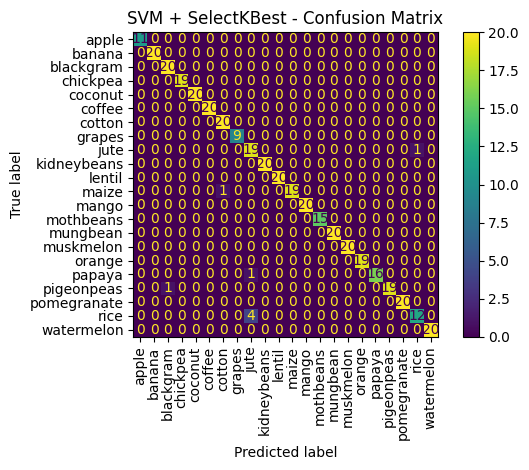


=== RandomForest with SelectKBest (N, P, K, humidity, rainfall) ===
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        11
      banana       1.00      1.00      1.00        20
   blackgram       1.00      0.95      0.97        20
    chickpea       1.00      1.00      1.00        19
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       0.95      1.00      0.98        20
      grapes       1.00      1.00      1.00         9
        jute       1.00      0.95      0.97        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      1.00      1.00        20
       maize       0.95      0.95      0.95        20
       mango       1.00      1.00      1.00        20
   mothbeans       1.00      1.00      1.00        15
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      1.00      1.00        20
      orange

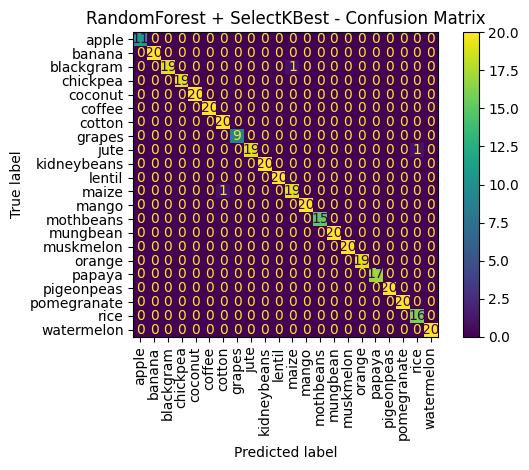


=== DecisionTree with SelectKBest (N, P, K, humidity, rainfall) ===
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        11
      banana       1.00      1.00      1.00        20
   blackgram       1.00      0.95      0.97        20
    chickpea       1.00      1.00      1.00        19
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       0.95      1.00      0.98        20
      grapes       1.00      1.00      1.00         9
        jute       1.00      0.95      0.97        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      0.95      0.97        20
       maize       0.95      0.95      0.95        20
       mango       1.00      1.00      1.00        20
   mothbeans       0.94      1.00      0.97        15
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      1.00      1.00        20
      orange

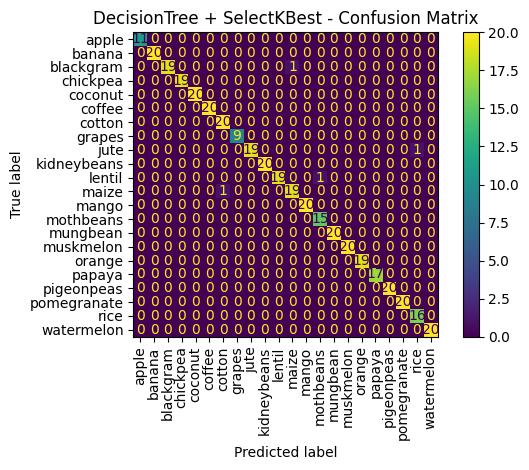


=== LogisticRegression with MutualInfo (humidity, rainfall, K, P, N) ===
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        11
      banana       1.00      1.00      1.00        20
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        19
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00         9
        jute       0.79      0.95      0.86        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      0.95      0.97        20
       maize       1.00      1.00      1.00        20
       mango       1.00      1.00      1.00        20
   mothbeans       0.94      1.00      0.97        15
    mungbean       0.83      1.00      0.91        20
   muskmelon       1.00      1.00      1.00        20
      o

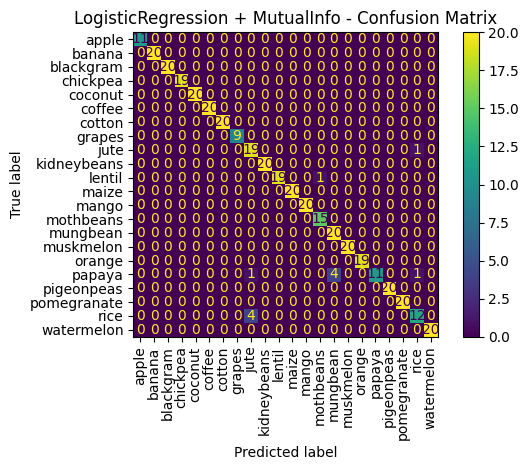


=== SVM with MutualInfo (humidity, rainfall, K, P, N) ===
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        11
      banana       1.00      1.00      1.00        20
   blackgram       0.95      1.00      0.98        20
    chickpea       1.00      1.00      1.00        19
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       0.95      1.00      0.98        20
      grapes       1.00      1.00      1.00         9
        jute       0.79      0.95      0.86        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      1.00      1.00        20
       maize       1.00      0.95      0.97        20
       mango       1.00      1.00      1.00        20
   mothbeans       1.00      1.00      1.00        15
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      1.00      1.00        20
      orange       1.0

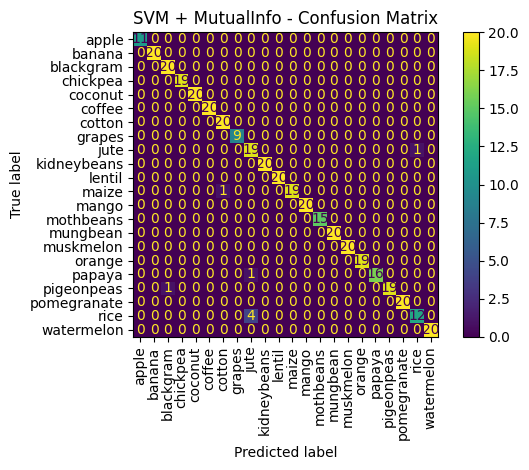


=== RandomForest with MutualInfo (humidity, rainfall, K, P, N) ===
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        11
      banana       1.00      1.00      1.00        20
   blackgram       1.00      0.95      0.97        20
    chickpea       1.00      1.00      1.00        19
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       0.95      1.00      0.98        20
      grapes       1.00      1.00      1.00         9
        jute       1.00      0.90      0.95        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      0.95      0.97        20
       maize       0.95      0.95      0.95        20
       mango       1.00      1.00      1.00        20
   mothbeans       0.94      1.00      0.97        15
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      1.00      1.00        20
      orange 

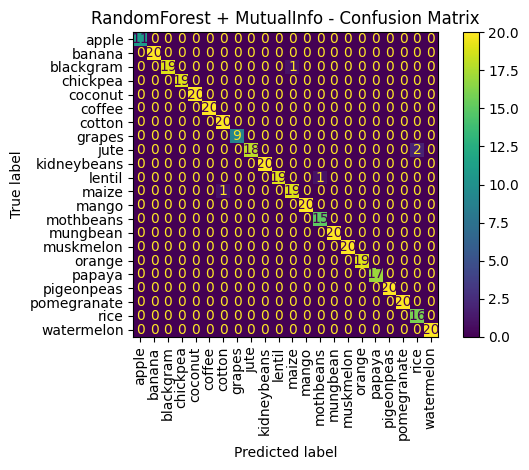


=== DecisionTree with MutualInfo (humidity, rainfall, K, P, N) ===
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        11
      banana       1.00      1.00      1.00        20
   blackgram       1.00      0.95      0.97        20
    chickpea       1.00      1.00      1.00        19
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       0.95      1.00      0.98        20
      grapes       1.00      1.00      1.00         9
        jute       1.00      0.95      0.97        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      0.95      0.97        20
       maize       0.95      0.95      0.95        20
       mango       1.00      1.00      1.00        20
   mothbeans       0.94      1.00      0.97        15
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      1.00      1.00        20
      orange 

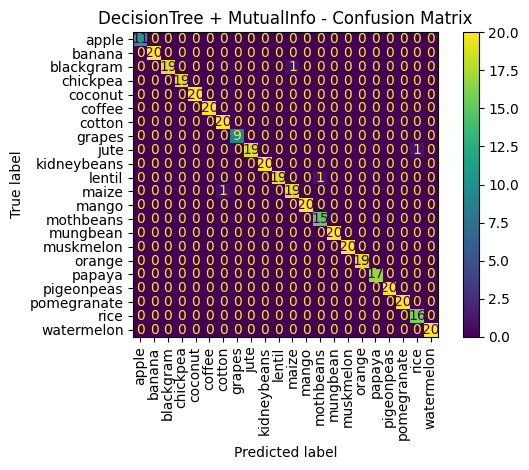


=== LogisticRegression with RandomForest (rainfall, humidity, K, P, N) ===
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        11
      banana       1.00      1.00      1.00        20
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        19
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00         9
        jute       0.79      0.95      0.86        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      0.95      0.97        20
       maize       1.00      1.00      1.00        20
       mango       1.00      1.00      1.00        20
   mothbeans       0.94      1.00      0.97        15
    mungbean       0.83      1.00      0.91        20
   muskmelon       1.00      1.00      1.00        20
     

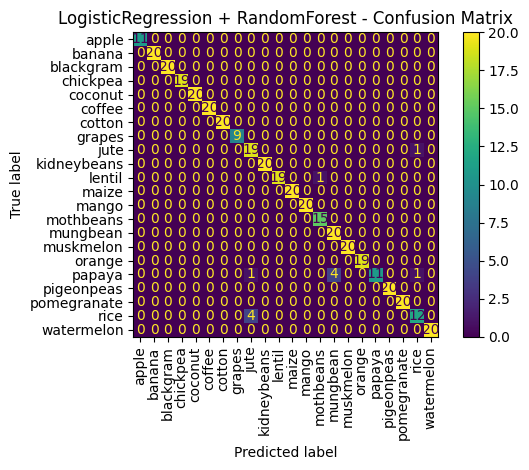


=== SVM with RandomForest (rainfall, humidity, K, P, N) ===
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        11
      banana       1.00      1.00      1.00        20
   blackgram       0.95      1.00      0.98        20
    chickpea       1.00      1.00      1.00        19
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       0.95      1.00      0.98        20
      grapes       1.00      1.00      1.00         9
        jute       0.79      0.95      0.86        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      1.00      1.00        20
       maize       1.00      0.95      0.97        20
       mango       1.00      1.00      1.00        20
   mothbeans       1.00      1.00      1.00        15
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      1.00      1.00        20
      orange       1

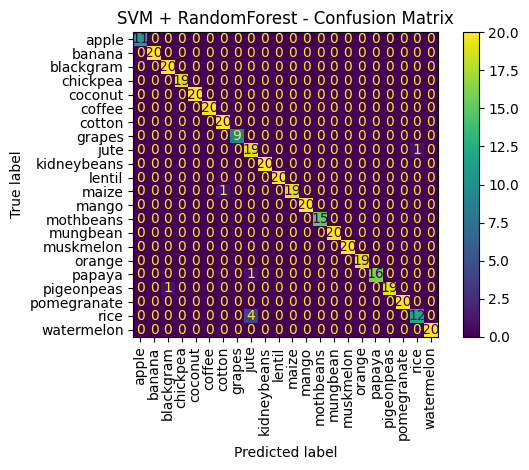


=== RandomForest with RandomForest (rainfall, humidity, K, P, N) ===
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        11
      banana       1.00      1.00      1.00        20
   blackgram       1.00      0.95      0.97        20
    chickpea       1.00      1.00      1.00        19
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       0.95      1.00      0.98        20
      grapes       1.00      1.00      1.00         9
        jute       0.95      0.90      0.92        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      1.00      1.00        20
       maize       0.95      0.95      0.95        20
       mango       1.00      1.00      1.00        20
   mothbeans       1.00      1.00      1.00        15
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      1.00      1.00        20
      orang

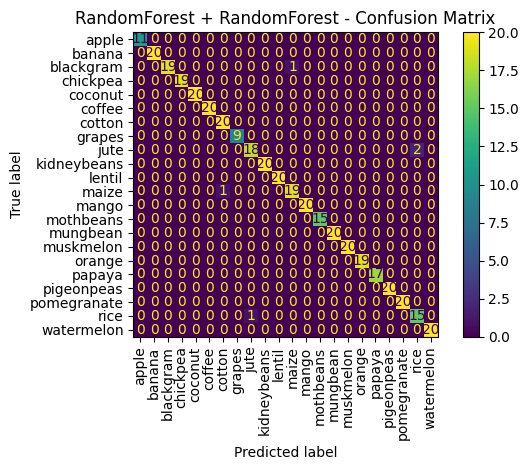


=== DecisionTree with RandomForest (rainfall, humidity, K, P, N) ===
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        11
      banana       1.00      1.00      1.00        20
   blackgram       1.00      0.95      0.97        20
    chickpea       1.00      1.00      1.00        19
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       0.95      1.00      0.98        20
      grapes       1.00      1.00      1.00         9
        jute       1.00      0.90      0.95        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      0.95      0.97        20
       maize       0.95      0.95      0.95        20
       mango       1.00      1.00      1.00        20
   mothbeans       0.94      1.00      0.97        15
    mungbean       0.95      1.00      0.98        20
   muskmelon       1.00      1.00      1.00        20
      orang

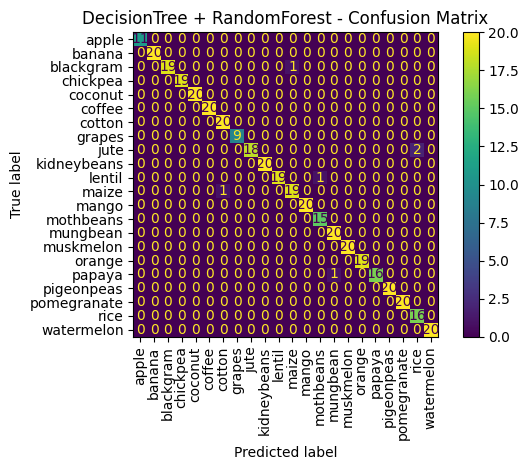


En iyi model: RandomForest with SelectKBest
F1-score (weighted avg): 0.9926
Selected features: ['N', 'P', 'K', 'humidity', 'rainfall']
Model ve ilgili bilgiler 'model/' klasorune kaydedildi.


In [25]:
#modellerin tanımlanması
feature_sets = {
    "SelectKBest": (X_kbest, features_kbest),
    "MutualInfo": (X_mi, features_mi),
    "RandomForest": (X_rf, features_rf)
}

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "SVM": SVC(probability=True),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42)
}

best_f1 = 0
best_model = None
best_model_name = ""
best_features_name = ""
best_features = None
best_scaler = None

for fs_name, (X_fs, features) in feature_sets.items():
    X_train, X_test, y_train, y_test = train_test_split(X_fs, y, test_size=0.2, random_state=42, stratify=y)

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        print(f"\n=== {model_name} with {fs_name} ({', '.join(features)}) ===")
        report = classification_report(y_test, y_pred, output_dict=True)
        print(classification_report(y_test, y_pred))


        f1_weighted = report['weighted avg']['f1-score']
        if f1_weighted > best_f1:
            best_f1 = f1_weighted
            best_model = model
            best_model_name = model_name
            best_features_name = fs_name
            best_features = features
            best_scaler = scaler

        cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
        disp.plot(xticks_rotation='vertical')
        plt.title(f"{model_name} + {fs_name} - Confusion Matrix")
        plt.tight_layout()
        plt.show()

print(f"\nEn iyi model: {best_model_name} with {best_features_name}")
print(f"F1-score (weighted avg): {best_f1:.4f}")
print(f"Selected features: {best_features}")


if not os.path.exists("model"):
    os.makedirs("model")


joblib.dump(best_model, "model/best_model.pkl")

joblib.dump(best_scaler, "model/scaler.pkl")

with open("model/model_info.txt", "w") as f:
    f.write(f"Model: {best_model_name}\n")
    f.write(f"Feature selection: {best_features_name}\n")
    f.write(f"Features: {', '.join(best_features)}\n")
    f.write(f"F1-score: {best_f1:.4f}\n")

print("Model ve ilgili bilgiler 'model/' klasorune kaydedildi.")


In [26]:
# model ve scaler'ı kaydet
import joblib
joblib.dump(rf, "crop_model_rf.pkl")
joblib.dump(scaler, "crop_scaler.pkl")


['crop_scaler.pkl']